In [1]:
%load_ext autoreload
%autoreload 2

from context import uncertify

In [2]:
import logging
from uncertify.log import setup_logging
setup_logging()
LOG = logging.getLogger(__name__)

# Matplotlib DEBUG logging spits out a whole bunch of crap
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [19]:
from functools import partial
from pathlib import Path

import torch
import torchvision
from tqdm import tqdm
try:
    tqdm._instances.clear()
except:
    pass
import seaborn as sns
sns.set_context("poster")
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})
from torch.utils.data import DataLoader

from uncertify.data.transforms import H_FLIP_TRANSFORM, V_FLIP_TRANSFORM
from uncertify.data.datasets import GaussianNoiseDataset
from uncertify.data.dataloaders import dataloader_factory, DatasetType

from uncertify.io.models import load_ensemble_models
from uncertify.utils.python_helpers import print_dict_tree, get_idx_of_closest_value

from uncertify.evaluation.ood_experiments import run_ood_evaluations, run_ood_to_ood_dict
from uncertify.evaluation.model_performance import calculate_roc, calculate_prc

from uncertify.visualization.ood_scores import plot_ood_scores, plot_most_least_ood, plot_samples_close_to_score
from uncertify.visualization.histograms import plot_multi_histogram
from uncertify.visualization.model_performance import setup_roc_prc_fig, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from uncertify.visualization.ood_scores import plot_ood_scores
from uncertify.visualization.entropy import plot_entropy_samples_over_range

from uncertify.common import DATA_DIR_PATH, HD_DATA_PATH

In [20]:
# Load models
RUN_VERSIONS = [1, 2, 3, 4, 5]
ensemble_models = load_ensemble_models(DATA_DIR_PATH / 'masked_ensemble_models', [f'model{idx}.ckpt' for idx in RUN_VERSIONS])
model = ensemble_models[0]

In [21]:
batch_size    = 155
USE_N_BATCHES = 10
NUM_WORKERS   = 0
SHUFFLE_VAL   = False

brats_t2_path    = HD_DATA_PATH / 'processed/brats17_t2_bc_std_bv3.5.hdf5'
brats_t2_hm_path = HD_DATA_PATH / 'processed/brats17_t2_hm_bc_std_bv3.5.hdf5'
brats_t1_path    = HD_DATA_PATH / 'processed/brats17_t1_bc_std_bv3.5.hdf5'
brats_t1_hm_path = HD_DATA_PATH / 'processed/brats17_t1_hm_bc_std_bv-3.5.hdf5'
camcan_t2_val_path   = DATA_DIR_PATH  / 'processed/camcan_val_t2_hm_std_bv3.5_xe.hdf5'
camcan_t2_train_path = DATA_DIR_PATH  / 'processed/camcan_train_t2_hm_std_bv3.5_xe.hdf5'

_, brats_val_t2_dataloader    = dataloader_factory(DatasetType.BRATS17, batch_size=batch_size, val_set_path=brats_t2_path, shuffle_val=SHUFFLE_VAL, num_workers=NUM_WORKERS)
_, brats_val_t1_dataloader    = dataloader_factory(DatasetType.BRATS17, batch_size=batch_size, val_set_path=brats_t1_path, shuffle_val=SHUFFLE_VAL, num_workers=NUM_WORKERS)
_, brats_val_t2_hm_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=batch_size, val_set_path=brats_t2_hm_path, shuffle_val=SHUFFLE_VAL, num_workers=NUM_WORKERS)
_, brats_val_t1_hm_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=batch_size, val_set_path=brats_t1_hm_path, shuffle_val=SHUFFLE_VAL, num_workers=NUM_WORKERS)


_, brats_val_t2_hflip_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=batch_size, val_set_path=brats_t2_path, shuffle_val=SHUFFLE_VAL, num_workers=NUM_WORKERS, transform=H_FLIP_TRANSFORM)
_, brats_val_t2_vflip_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=batch_size, val_set_path=brats_t2_path, shuffle_val=SHUFFLE_VAL, num_workers=NUM_WORKERS, transform=V_FLIP_TRANSFORM)

camcan_train_dataloader, camcan_val_dataloader = dataloader_factory(DatasetType.CAMCAN, batch_size=batch_size, val_set_path=camcan_t2_val_path, train_set_path=camcan_t2_train_path, shuffle_val=SHUFFLE_VAL, shuffle_train=True, num_workers=NUM_WORKERS)
camcan_lesional_train_dataloader, camcan_lesional_val_dataloader = dataloader_factory(DatasetType.CAMCAN, batch_size=batch_size, val_set_path=camcan_t2_val_path, train_set_path=camcan_t2_train_path, shuffle_val=False, shuffle_train=True, num_workers=NUM_WORKERS, add_gauss_blobs=True)

noise_set = GaussianNoiseDataset()
noise_loader = DataLoader(noise_set, batch_size=batch_size)

_, mnist_val_dataloader = dataloader_factory(DatasetType.MNIST, batch_size=batch_size, transform=torchvision.transforms.Compose([
                                                                        torchvision.transforms.Resize((128, 128)),
                                                                        torchvision.transforms.ToTensor()
                                                                    ])
                         )

dataloader_dict = {'BraTS T2 val': brats_val_t2_dataloader, 
                   #'BraTS T1 val': brats_val_t1_dataloader, 
                   #'CamCAN lesion train': camcan_lesional_val_dataloader,
                   #'CamCAN lesion val': camcan_lesional_val_dataloader,
                   #'BraTS T2 HM val': brats_val_t2_hm_dataloader, 
                   #'BraTS T1 HM val': brats_val_t1_hm_dataloader,
                   #'CamCAN train': camcan_train_dataloader,
                   #'CamCAN val': camcan_val_dataloader,
                   #'Gaussian noise': noise_loader,
                   #'MNIST': mnist_val_dataloader,
                   #'BraTS T2 HFlip': brats_val_t2_hflip_dataloader,
                   #'BraTS T2 VFlip': brats_val_t2_vflip_dataloader
}
brats_dataloader_dict = {key: val for key, val in dataloader_dict.items() if 'BraTS' in key}

for name, dataloader in dataloader_dict.items(): 
    print(f'{name:15} dataloader: {len(dataloader)} batches (batch_size: {dataloader.batch_size}) -> {len(dataloader) * dataloader.batch_size} samples.')

BraTS T2 val    dataloader: 255 batches (batch_size: 155) -> 39525 samples.


# OOD Detection Evaluation for different OOD datasets

In [ ]:
# Runs full OOD evaluation (stores ourput) all datasets and metrics in evaluation config
run_ood_evaluations(camcan_train_dataloader,
                    dataloader_dict,
                    ensemble_models,
                    residual_threshold=0.95,
                    max_n_batches=5)

# OOD Score

In [37]:
NUM_BACTHES = 10
OOD_METRICS = ('dose', )  # 'waic', 
DOSE_STATISTICS = ('entropy', 'elbo', 'kl_div', 'rec_err')  # 'elbo', 'kl_div', 'rec_err', 

dataloader_dict = {'BraTS T2': brats_val_t2_dataloader, 
                   #'BraTS T1': brats_val_t1_dataloader, 
                   #'BraTS T2 HM': brats_val_t2_hm_dataloader,
                   #'BraTS T1 HM': brats_val_t1_hm_dataloader,
                   #'CamCAN train': camcan_train_dataloader,
                   #'Gaussian noise': noise_loader,
                   #'MNIST': mnist_val_dataloader
}

metrics_ood_dict = run_ood_to_ood_dict(dataloader_dict, ensemble_models, camcan_train_dataloader,
                                       num_batches=NUM_BACTHES, ood_metrics=OOD_METRICS,
                                       dose_statistics=DOSE_STATISTICS)
print_dict_tree(metrics_ood_dict)

2020-12-17 21:55:22,350 : uncertify.evaluation.waic : INFO       Fitting training data statistics on camcan_train_t2_hm_std_bv3.5_xe.hdf5


Inferring batches (slice statistics camcan_train_t2_hm_std_bv3.5_xe.hdf5): 11it [00:55,  5.53s/it]                        


ValueError: array must not contain infs or NaNs

2020-12-17 22:05:28,489 : uncertify.visualization.entropy : INFO       Plotting scans with entropy from 0.0-15.5.
2020-12-17 22:05:28,491 : uncertify.visualization.entropy : INFO       Min/max entropy from all healthy scans is: 0.0/15.3
2020-12-17 22:05:28,492 : uncertify.visualization.entropy : INFO       Min/max entropy from all lesional scans is: 0.9/15.3


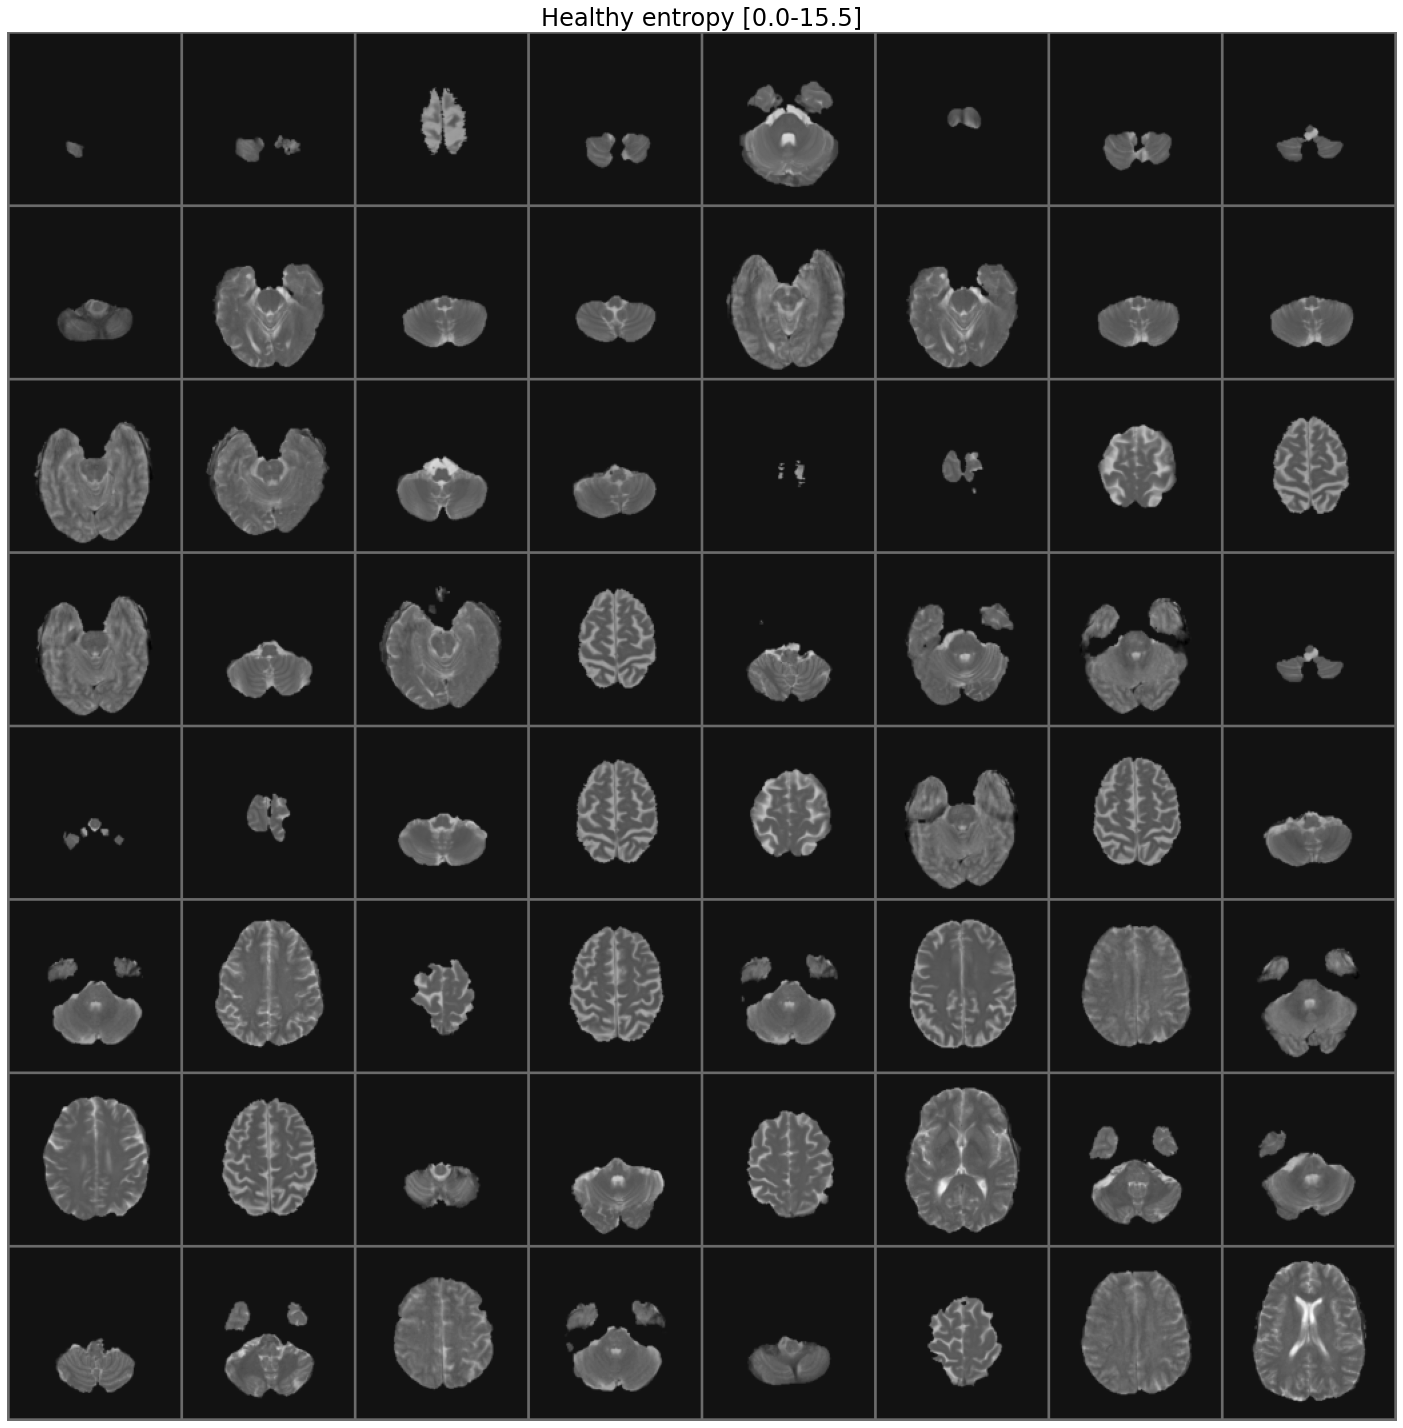

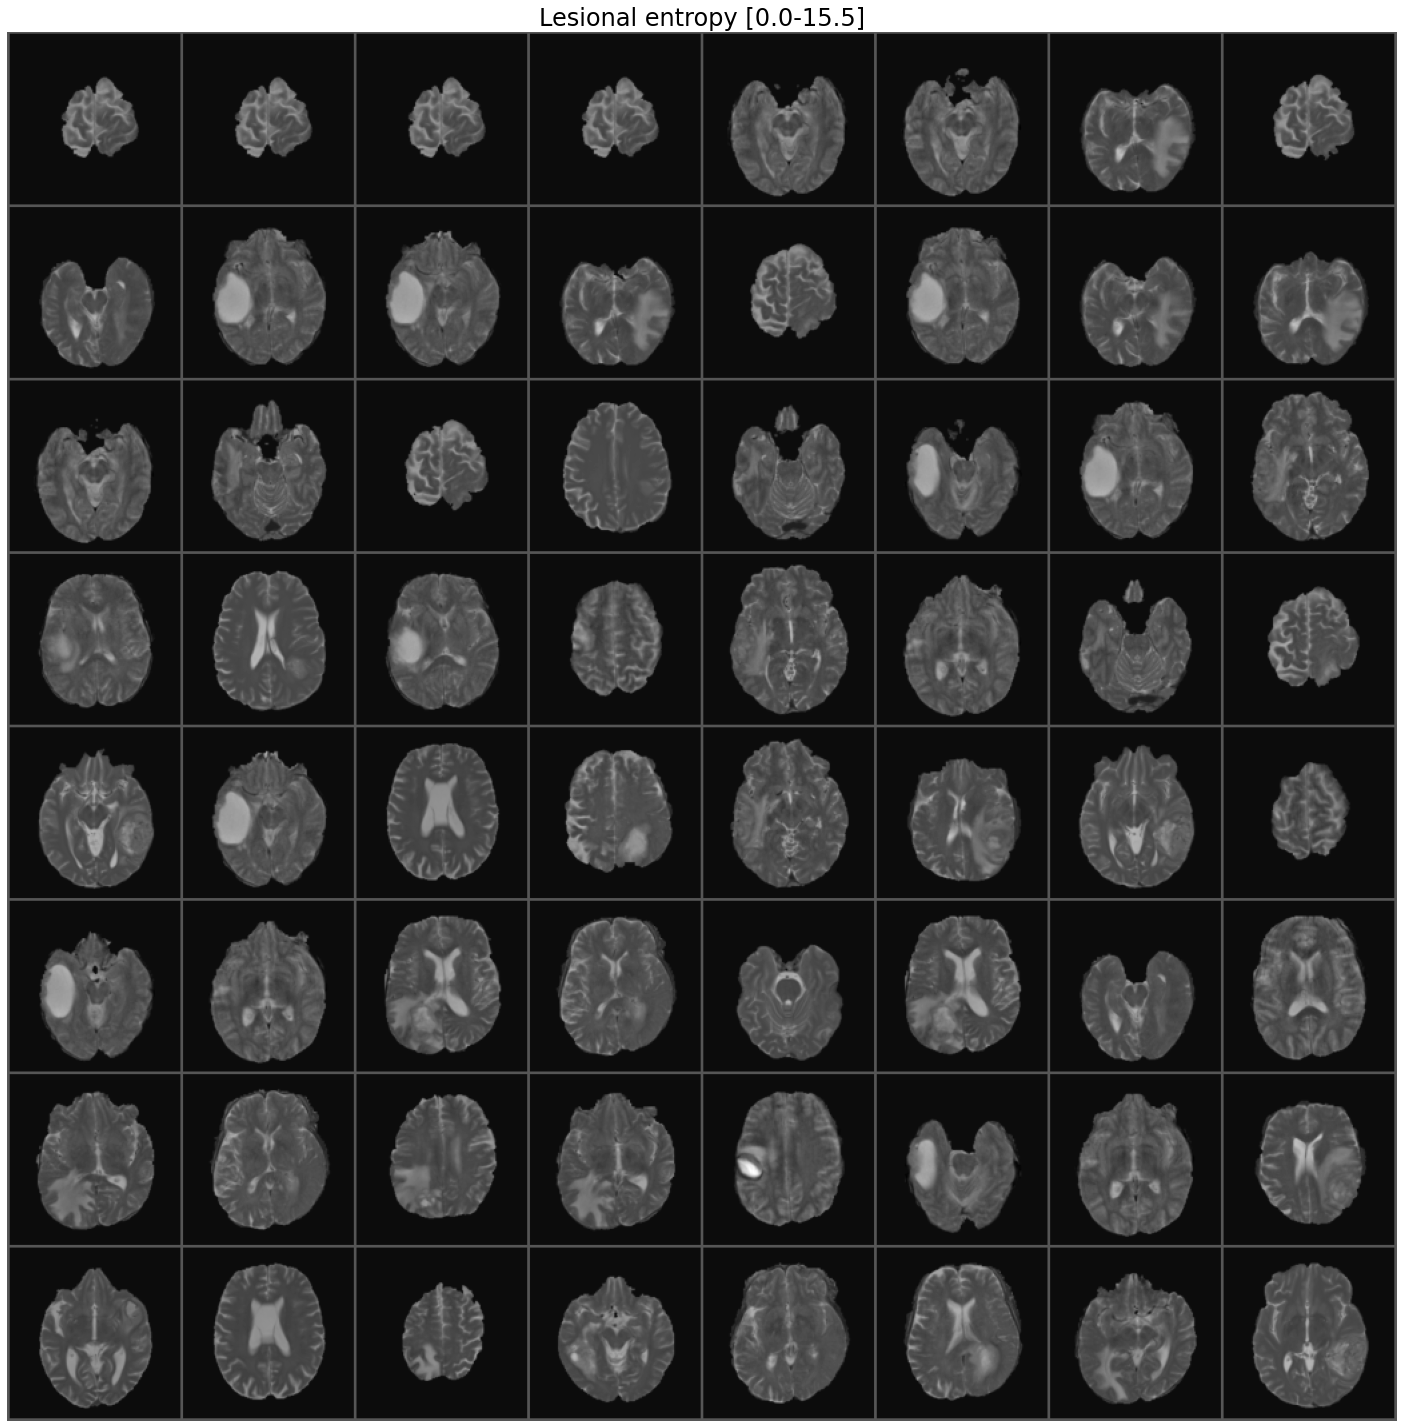

In [44]:
plot_entropy_samples_over_range(metrics_ood_dict, 'BraTS T2', 0, 15.5, 64,
                                axis='off', add_colorbar=False, figsize=(20, 20), cmap='gray')

In [45]:
# Check for different DoSE KDE stats whether they can distinguish between healthy and unhealthy

for dataloader_name in dataloader_dict.keys():
    if 'can' in dataloader_name.lower():
        continue
    print()
    print(f' --- {dataloader_name} --- ')
    for post_kde_stat in list(DOSE_STATISTICS) + ['_'.join(list(DOSE_STATISTICS))]:
        print(f'{post_kde_stat}')
        if post_kde_stat == '_'.join(DOSE_STATISTICS):
            healthy_post_kde = metrics_ood_dict['dose'][dataloader_name]['healthy']
            lesional_post_kde = metrics_ood_dict['dose'][dataloader_name]['lesional']
        else:
            healthy_post_kde = metrics_ood_dict['dose'][dataloader_name]['dose_kde_healthy'][post_kde_stat]
            lesional_post_kde = metrics_ood_dict['dose'][dataloader_name]['dose_kde_lesional'][post_kde_stat]
        #print(f'{len(healthy_post_kde)} healthy / {len(lesional_post_kde)} lesional samples')
        
        y_true = len(healthy_post_kde) * [0.0] + len(lesional_post_kde) * [1.0]
        y_pred_proba = healthy_post_kde + lesional_post_kde

        fpr, tpr, _, au_roc = calculate_roc(y_true, -np.array(y_pred_proba))
        precision, recall, _, au_prc = calculate_prc(y_true, -np.array(y_pred_proba))

        plot_roc_curve(fpr, tpr, au_roc)
        plot_precision_recall_curve(recall, precision, au_prc)

        plot_multi_histogram([-np.array(healthy_post_kde), -np.array(lesional_post_kde)],
                             ['healthy', 'lesional'],
                             plot_density=False,
                             show_data_ticks=False,
                             legend_title='$DoSE_{KDE}$' + f'({post_kde_stat})',
                             legend_pos='upper left')
        
        print(f'\tAUROC: {au_roc:.2f}')
        print(f'\tAUPRC: {au_prc:.2f}')


 --- BraTS T2 --- 
entropy


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

2020-12-17 22:14:59,220 : uncertify.visualization.ood_scores : INFO       Saved OOD score figure at: /home/juniors/code/uncertify/data/plots/dose.png


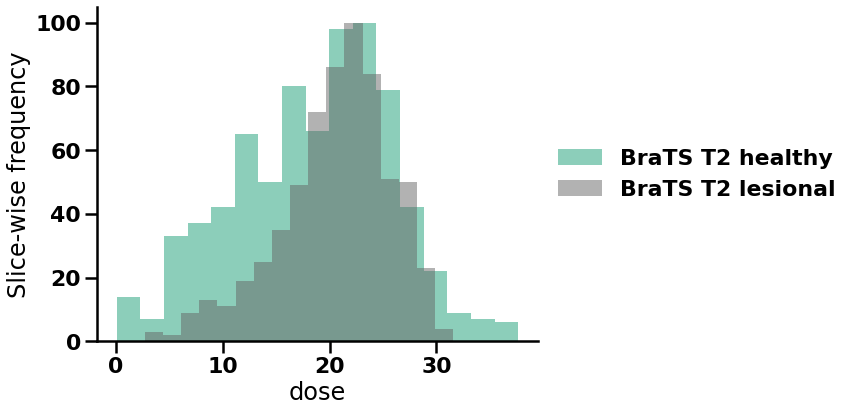

In [46]:
for metric in OOD_METRICS:
    n = 8
    ood_dict = metrics_ood_dict[metric]
    plot_ood_scores(ood_dict, score_label=metric, dataset_name_filters=[], modes_to_include=['healthy', 'lesional'])

    #plot_most_least_ood(ood_dict, 'BraTS T2', n_most=n)
    #plot_most_least_ood(ood_dict, 'CamCAN train', do_lesional=False, n_most=n)

    #plot_samples_close_to_score(ood_dict, 'BraTS T2', min_score=0, max_score=25, n=n, show_ground_truth=False, print_score=True)
    #plot_samples_close_to_score(ood_dict, 'CamCAN train', do_lesional=False, show_ground_truth=False, min_score=0, max_score=25, n=n, print_score=True)


# Slice-Wise Statistics

In [47]:
import pandas as pd
import seaborn as sns

from uncertify.evaluation.dose import full_pipeline_slice_wise_dose_scores
from uncertify.evaluation.statistics import fit_statistics, aggregate_slice_wise_statistics
from uncertify.visualization.dose import do_pair_plot_statistics

In [ ]:
# Plot the fitted training statistics as a lower triangular pair-plot
DOSE_STATISTICS = ['elbo', 'rec_err', 'kl_div', 'entropy']
MAX_N_BATCHES = 10


stat_dataloader_dict = {'BraTS T2': brats_val_t2_dataloader,
                   #'BraTS T1': brats_val_t1_dataloader,
                   #'BraTS T2 HM': brats_val_t2_hm_dataloader,
                   #'BraTS T1 HM': brats_val_t1_hm_dataloader,
                   'CamCAN train': camcan_train_dataloader,
                   #'Gaussian noise': noise_loader,
                   #'MNIST': mnist_val_dataloader
}

stat_frames = {}

for name, dataloader in stat_dataloader_dict.items():
    hue = 'is_lesional' if dataloader is not camcan_train_dataloader else None
    statistics_dict = aggregate_slice_wise_statistics(model, dataloader,
                                                      DOSE_STATISTICS, max_n_batches=MAX_N_BATCHES)
    stat_df = pd.DataFrame(statistics_dict)
    do_pair_plot_statistics(statistics_dict, DOSE_STATISTICS, dataloader.dataset.name, hue=hue)
    stat_frames[name] = stat_df

    plt.figure()
    sns.histplot(stat_df, x='entropy', hue=hue, kde=True)
    ax = plt.gca()
    ax.set_xlim([0, 0.16])

Inferring batches (slice statistics brats17_t2_bc_std_bv3.5.hdf5):  20%|██        | 2/10 [00:04<00:34,  4.35s/it]

In [ ]:
for name, stat_df in stat_frames.items():
    plt.figure()
    sns.histplot(stat_df, x='entropy', hue='is_lesional' if 'Cam' not in name else None, kde=True)
    ax = plt.gca()
    ax.set_xlim([0, 0.26])

In [ ]:
from uncertify.utils.python_helpers import get_idx_of_closest_value

# Plot lesional and healthy samples which are close to some score (entropy)

ref_values = np.linspace(0.05, 0.25, 40)

brats_stats = stat_frames['BraTS T2']
is_lesional = brats_stats['is_lesional']
lesional_scans = list(brats_stats['scans'][is_lesional])
healthy_scans = list(brats_stats['scans'][np.invert(is_lesional)])
lesional_entropy = list(brats_stats['entropy'][is_lesional])
healthy_entropy = list(brats_stats['entropy'][np.invert(is_lesional)])


for ref_val in ref_values:
    healthy_ids = get_idx_of_closest_value(healthy_entropy, ref_val)
    lesional_ids = get_idx_of_closest_value(lesional_entropy, ref_val)
    
    plt.subplots(figsize=(2, 2))
    plt.imshow(lesional_scans[lesional_ids][0].numpy())
    plt.title(f'[lesional]\n entropy={lesional_entropy[lesional_ids]:.3f}')
    plt.axis('off')
    plt.show()
    
    plt.subplots(figsize=(2, 2))
    plt.imshow(healthy_scans[healthy_ids][0].numpy())
    plt.title(f'[healthy]\n entropy={healthy_entropy[healthy_ids]:.3f}')
    plt.axis('off')
    plt.show()

In [ ]:
for stat_df, hue in zip(stat_frames.values(), ['is_lesional', None]):
    plt.figure()
    sns.histplot(stat_df, x='entropy', hue=hue, kde=True)
    ax = plt.gca()
    ax.set_xlim([0, 0.26])

In [ ]:
# Plot the DoSE KDE scores on a fitted training distribution
MAX_N_BATCHES = 5
test_dataloaders = [camcan_train_dataloader, brats_val_t2_dataloader] #[brats_val_t2_dataloader, brats_val_t1_dataloader, camcan_train_dataloader]
has_lesional_data = [False, True] # [True, True, False]

kde_func_dict = fit_statistics(statistics_dict)
for dataloader, has_lesions in zip(test_dataloaders, has_lesional_data):
    dose_scores, dose_kde_dict = full_pipeline_slice_wise_dose_scores(camcan_train_dataloader, dataloader, model,
                                                                      DOSE_STATISTICS, MAX_N_BATCHES, kde_func_dict)
    do_pair_plot_statistics(dose_kde_dict, DOSE_STATISTICS, dataloader.dataset.name, 'is_lesional' if has_lesions else None)

# Plotting Final Dose Statistics

In [ ]:
# Fitting statistics on training data
statistics_dict = aggregate_slice_wise_statistics(model, camcan_train_dataloader, DOSE_STATISTICS, max_n_batches=50)
kde_func_dict = fit_statistics(statistics_dict)

# Computing dose scores on OOD dataset
dose_scores, dose_kde_dict = full_pipeline_slice_wise_dose_scores(camcan_train_dataloader, brats_val_t2_dataloader, model, 
                                                                    DOSE_STATISTICS, MAX_N_BATCHES, kde_func_dict)
final_dose_df = pd.DataFrame({'DoSE': dose_scores, 'is_lesional': dose_kde_dict['is_lesional']})
sns.kdeplot(final_dose_df.DoSE, hue=final_dose_df.is_lesional)

# Computing dose scores on ID dataset
dose_scores, dose_kde_dict = full_pipeline_slice_wise_dose_scores(camcan_train_dataloader, camcan_train_dataloader, model, 
                                                                    DOSE_STATISTICS, 3, kde_func_dict)
final_dose_df = pd.DataFrame({'DoSE': dose_scores, 'is_lesional': dose_kde_dict['is_lesional']})
sns.kdeplot(final_dose_df.DoSE, hue=final_dose_df.is_lesional)